<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Preprocesamiento de datos y creación de datasets para forecast</h4>
</center>

In [18]:
# Importación librerias

# !pip install awswrangler
# !pip install boto3
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [3]:
# Definición fechas

date_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

# Versión modelo
data_version_cluster1 = '4_c1'
data_version_cluster2 = '4_c2'
data_version_cluster3 = '4_c3'
grouped_cols = "product_id"
grouped_cols_name = "product"

Fecha inicio historia 2017-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


In [4]:
# Conexiones AWS

account_id=boto3.client('sts').get_caller_identity().get('Account')
session = boto3.Session() 
forecast = session.client(service_name='forecast')
region = forecast.meta.region_name
forecastquery = session.client(service_name='forecastquery')

In [31]:
# Buckets de datos

# CLUSTER 1
target_s3_path_c1=f's3://datasets-forecast-account1/modelo-{data_version_cluster1}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path_c1=f's3://datasets-forecast-account1/modelo-{data_version_cluster1}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path_c1=f's3://datasets-forecast-account1/modelo-{data_version_cluster1}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

# CLUSTER 2
target_s3_path_c2=f's3://datasets-forecast-account1/modelo-{data_version_cluster2}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path_c2=f's3://datasets-forecast-account1/modelo-{data_version_cluster2}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path_c2=f's3://datasets-forecast-account1/modelo-{data_version_cluster2}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

# CLUSTER 3
target_s3_path_c3=f's3://datasets-forecast-account1/modelo-{data_version_cluster3}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path_c3=f's3://datasets-forecast-account1/modelo-{data_version_cluster3}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path_c3=f's3://datasets-forecast-account1/modelo-{data_version_cluster3}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

In [7]:
# Verificar comunicación con Amazon Forecast
assert forecast.list_predictors()

### Procesamiento de datos de ventas

- Skus a predecir

In [8]:
skus_a_predecir = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/productos_a_predecir.txt", delimiter='\t')
skus_a_predecir = skus_a_predecir.product_id.to_list()

- Datos de ventas

In [9]:
df_ventas = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/sell-in.txt", delimiter='\t')
df_ventas['periodo'] = df_ventas['periodo'].astype(str)
df_ventas['periodo'] = pd.to_datetime(df_ventas['periodo'], format='%Y%m')
df_ventas = df_ventas[df_ventas.product_id.isin(skus_a_predecir)]
df_ventas.head(1)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,2017-01-01,10234,20524,0,2,0.053,0.053


In [10]:
print(f"Cantidad productos finales a predecir: {len(df_ventas.product_id.drop_duplicates())}")

Cantidad productos finales a predecir: 780


In [11]:
df_ventas_product = df_ventas.groupby(["periodo", "product_id"])["tn"].sum().reset_index()
df_ventas_product.head(1)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222


In [12]:
df_ventas_product.isna().sum()

periodo       0
product_id    0
tn            0
dtype: int64

In [13]:
df_ventas_product.tn.sum().round(1) == df_ventas.tn.sum().round(1) 

True

- Preprocesamiento para armado clusters

In [41]:
df_pivot = df_ventas_product.pivot(index='periodo',
                                   columns='product_id',
                                   values='tn')

print(df_pivot.shape, df_pivot.columns)

df_pivot.head()

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,798.01620,505.88633,752.11520,508.20044,551.43060,599.18590,638.62996,631.71430,475.24200,562.98287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,1303.35771,834.73521,917.16548,489.91328,563.89955,868.34182,840.83303,937.42393,456.07282,718.44870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,1069.96130,522.35365,525.82591,512.05402,662.59032,565.31925,741.17156,626.51768,338.71860,607.72864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,1502.20132,843.43785,620.48202,543.36670,515.58711,813.17643,858.04498,849.48973,455.37110,759.99707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# resample time series data and fill missing values with 0s
df_pivot.index = pd.DatetimeIndex(df_pivot.index)

df_pivot = df_pivot.resample('MS').sum().fillna(0)

print(df_pivot.shape, df_pivot.columns)

df_pivot.head()

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-01,798.01620,505.88633,752.11520,508.20044,551.43060,599.18590,638.62996,631.71430,475.24200,562.98287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-01,1303.35771,834.73521,917.16548,489.91328,563.89955,868.34182,840.83303,937.42393,456.07282,718.44870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-01,1069.96130,522.35365,525.82591,512.05402,662.59032,565.31925,741.17156,626.51768,338.71860,607.72864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-01,1502.20132,843.43785,620.48202,543.36670,515.58711,813.17643,858.04498,849.48973,455.37110,759.99707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# transpose data to match format neeed for further processing
df_pivoted = df_pivot.T
df_pivoted = df_pivoted.reset_index()

print(df_pivoted.shape, df_pivoted.columns)

df_pivoted.set_index('product_id', inplace=True)
df_pivoted.head(5)

(780, 37) Index([       'product_id', 2017-01-01 00:00:00, 2017-02-01 00:00:00,
       2017-03-01 00:00:00, 2017-04-01 00:00:00, 2017-05-01 00:00:00,
       2017-06-01 00:00:00, 2017-07-01 00:00:00, 2017-08-01 00:00:00,
       2017-09-01 00:00:00, 2017-10-01 00:00:00, 2017-11-01 00:00:00,
       2017-12-01 00:00:00, 2018-01-01 00:00:00, 2018-02-01 00:00:00,
       2018-03-01 00:00:00, 2018-04-01 00:00:00, 2018-05-01 00:00:00,
       2018-06-01 00:00:00, 2018-07-01 00:00:00, 2018-08-01 00:00:00,
       2018-09-01 00:00:00, 2018-10-01 00:00:00, 2018-11-01 00:00:00,
       2018-12-01 00:00:00, 2019-01-01 00:00:00, 2019-02-01 00:00:00,
       2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00,
       2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00,
       2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00,
       2019-12-01 00:00:00],
      dtype='object', name='periodo')


periodo,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,
20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,1439.75563,...,1470.65653,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856
20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.71078,1065.34529,857.45269,...,1083.62552,1287.62346,1034.98927,928.36431,1066.44999,813.78215,1090.18771,1979.53635,1423.57739,1087.30855
20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.21928,1465.83347,1958.59845,...,638.04010,565.33774,590.12515,662.38654,715.20314,635.59563,967.77116,1081.36645,948.29393,892.50129
20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.52979,1259.64560,1268.21209,...,619.77084,466.70901,603.31081,667.19411,521.71519,482.13372,786.17140,1064.69633,723.94206,637.90002
20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1068.01865,1247.88880,875.13411,...,488.21387,624.99880,897.26297,876.39696,745.74978,536.66800,879.52808,996.78275,606.91173,593.24443


In [45]:
%%time

# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

(780, 36, 1) (780, 36, 1)
CPU times: total: 188 ms
Wall time: 182 ms


In [46]:
# create required directory structure
dir_paths = ['./tsl_LABO', './tsl_LABO/models', './tsl_LABO/plots']

for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [47]:
%%time

# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 3

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)

model.to_pickle(f"./tsl_LABO/models/{algo}.pkl")

CPU times: total: 41.5 s
Wall time: 40.9 s


In [48]:
# backup clustering results
np.save(f"C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/3. AWS Forecast/Modelo 4/tls_{algo}_cluster_labels", y_pred)

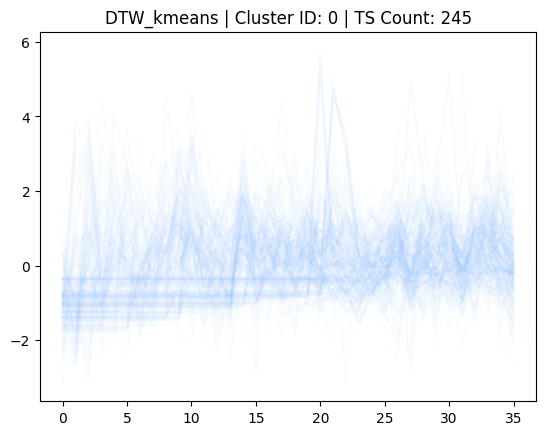

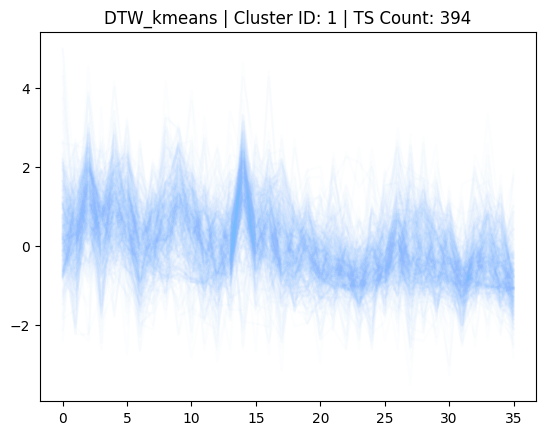

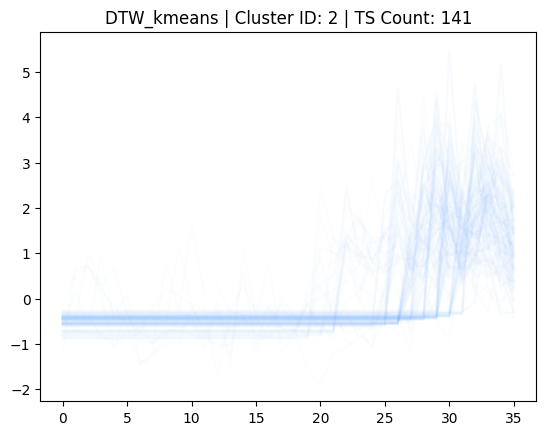

CPU times: total: 2.36 s
Wall time: 2.44 s


In [49]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.025)
    fig.savefig(f"./tsl_LABO/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [50]:
len(df_pivoted)

780

In [51]:
len(y_pred)

780

In [52]:
df_pivoted_extended = pd.concat([df_pivoted.reset_index(), pd.DataFrame(y_pred, columns = ["cluster_id"])], axis = 1)
df_pivoted_extended

,product_id,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,...,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,cluster_id
0,20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,...,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856,0
1,20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.71078,1065.34529,...,1287.62346,1034.98927,928.36431,1066.44999,813.78215,1090.18771,1979.53635,1423.57739,1087.30855,0
2,20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.21928,1465.83347,...,565.33774,590.12515,662.38654,715.20314,635.59563,967.77116,1081.36645,948.29393,892.50129,0
3,20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.52979,1259.64560,...,466.70901,603.31081,667.19411,521.71519,482.13372,786.17140,1064.69633,723.94206,637.90002,0
4,20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1068.01865,1247.88880,...,624.99880,897.26297,876.39696,745.74978,536.66800,879.52808,996.78275,606.91173,593.24443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,21263,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.01835,0.02258,0.00988,0.03387,0.03388,0.01128,0.01552,0.03247,0.01270,0
776,21265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.36405,0.17635,0.05121,0.02959,0.01593,0.01707,0.10921,0.06600,0.05007,0
777,21266,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.36178,0.17634,0.05235,0.05916,0.01480,0.02844,0.11831,0.06713,0.05121,0
778,21267,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.12291,0.24451,0.05882,0.07452,0.04054,0.01830,0.09676,0.04052,0.01569,0


In [53]:
df_tts = pd.melt(df_pivoted_extended, id_vars=['product_id', 'cluster_id'])
df_tts.columns = ['product_id', 'cluster_id', 'periodo', 'tn']
df_tts = df_tts[['periodo', 'product_id', 'cluster_id', 'tn']]
df_tts

,periodo,product_id,cluster_id,tn
0,2017-01-01,20001,0,934.77222
1,2017-01-01,20002,0,550.15707
2,2017-01-01,20003,0,1063.45835
3,2017-01-01,20004,0,555.91614
4,2017-01-01,20005,0,494.27011
...,...,...,...,...
28075,2019-12-01,21263,0,0.01270
28076,2019-12-01,21265,0,0.05007
28077,2019-12-01,21266,0,0.05121
28078,2019-12-01,21267,0,0.01569


In [54]:
len(df_tts[df_tts.tn != 0]) == len(df_ventas_product)
# df_tts tiene más registros porque las fechas sin tn por serie fueron completados con 0

True

In [55]:
df_tts.tn.sum()

1122605.2173000001

In [56]:
df_ventas_product.tn.sum()

1122605.2173000001

In [70]:
df_tts["periodo"] = pd.to_datetime(df_tts['periodo'], format='%Y%m')

df_ventas_product_cluster1 = df_tts[df_tts.cluster_id == 0]
df_ventas_product_cluster1 = df_ventas_product_cluster1.drop(columns = {"cluster_id"})
print("---------------C1---------------")
print(df_ventas_product_cluster1.periodo.min(), df_ventas_product_cluster1.periodo.max())
print(len(df_ventas_product_cluster1.drop_duplicates(subset = "product_id")))

df_ventas_product_cluster2 = df_tts[df_tts.cluster_id == 1]
df_ventas_product_cluster2 = df_ventas_product_cluster2.drop(columns = {"cluster_id"})
print("---------------C2---------------")
print(df_ventas_product_cluster2.periodo.min(), df_ventas_product_cluster2.periodo.max())
print(len(df_ventas_product_cluster2.drop_duplicates(subset = "product_id")))

df_ventas_product_cluster3 = df_tts[df_tts.cluster_id == 2]
df_ventas_product_cluster3 = df_ventas_product_cluster3.drop(columns = {"cluster_id"})
print("---------------C3---------------")
print(df_ventas_product_cluster3.periodo.min(), df_ventas_product_cluster3.periodo.max())
print(len(df_ventas_product_cluster3.drop_duplicates(subset = "product_id")))

---------------C1---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
245
---------------C2---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
394
---------------C3---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
141


In [71]:
len(df_ventas_product_cluster1.drop_duplicates(subset = "product_id")) + len(df_ventas_product_cluster2.drop_duplicates(subset = "product_id")) + len(df_ventas_product_cluster3.drop_duplicates(subset = "product_id"))

780

In [85]:
# Exportamos data de ventas product, CLUSTER 1
df_ventas_product_cluster1_export = df_ventas_product_cluster1[(df_ventas_product_cluster1['periodo']>=date_start) & (df_ventas_product_cluster1['periodo']<=date_end)]
df_ventas_product_cluster1_export['product_id'] = df_ventas_product_cluster1_export['product_id'].astype(str)
print("Cantidad items: " + str(len(df_ventas_product_cluster1_export.drop_duplicates(subset = "product_id"))))
print(f"Min periodo {df_ventas_product_cluster1_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_cluster1_export.periodo.max()}")
print(f"Tipos por columna: \n{df_ventas_product_cluster1_export.dtypes}")
wr.s3.to_csv(df_ventas_product_cluster1_export, target_s3_path_c1, index=False, header=False)

Cantidad items: 245
Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c1-forecast-product/target/df_ventas_product.csv'],
 'partitions_values': {}}

In [86]:
# Exportamos data de ventas product, CLUSTER 2
df_ventas_product_cluster2_export = df_ventas_product_cluster2[(df_ventas_product_cluster2['periodo']>=date_start) & (df_ventas_product_cluster2['periodo']<=date_end)]
df_ventas_product_cluster2_export['product_id'] = df_ventas_product_cluster2_export['product_id'].astype(str)
print("Cantidad items: " + str(len(df_ventas_product_cluster2_export.drop_duplicates(subset = "product_id"))))
print(f"Min periodo {df_ventas_product_cluster2_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_cluster2_export.periodo.max()}")
print(f"Tipos por columna: \n{df_ventas_product_cluster2_export.dtypes}")
wr.s3.to_csv(df_ventas_product_cluster2_export, target_s3_path_c2, index=False, header=False)

Cantidad items: 394
Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c2-forecast-product/target/df_ventas_product.csv'],
 'partitions_values': {}}

In [87]:
# Exportamos data de ventas product, CLUSTER 3
df_ventas_product_cluster3_export = df_ventas_product_cluster3[(df_ventas_product_cluster3['periodo']>=date_start) & (df_ventas_product_cluster3['periodo']<=date_end)]
df_ventas_product_cluster3_export['product_id'] = df_ventas_product_cluster3_export['product_id'].astype(str)
print("Cantidad items: " + str(len(df_ventas_product_cluster3_export.drop_duplicates(subset = "product_id"))))
print(f"Min periodo {df_ventas_product_cluster3_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_cluster3_export.periodo.max()}")
print(f"Tipos por columna: \n{df_ventas_product_cluster3_export.dtypes}")
wr.s3.to_csv(df_ventas_product_cluster3_export, target_s3_path_c3, index=False, header=False)

Cantidad items: 141
Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c3-forecast-product/target/df_ventas_product.csv'],
 'partitions_values': {}}

### Procesamiento de datos de productos

In [65]:
producto = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/tb_productos.txt", delimiter='\t')
producto.head(5)

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [66]:
print("----ANALISIS DUPLICADOS-----")
print(f"Cantidad productos en maestro productos: {len(producto)}")
print(f"Cantidad productos en maestro productos sin repetidos: {len(producto.product_id.drop_duplicates())}")
# Observamos que product_id duplicados tienen los mismos valores en las otras columnas, son duplicados y procedemos a eliminarlos 
producto = producto.drop_duplicates(subset = "product_id")
print(f"Cantidad productos en maestro productos: {len(producto)}")

----ANALISIS DUPLICADOS-----
Cantidad productos en maestro productos: 1262
Cantidad productos en maestro productos sin repetidos: 1251
Cantidad productos en maestro productos: 1251


In [67]:
producto = producto[producto.product_id.isin(skus_a_predecir)]
print(f"Cantidad productos finales a predecir: {len(producto)}")

Cantidad productos finales a predecir: 780


In [68]:
producto = producto[["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]]

In [80]:
# Exportamos data de product, CLUSTER 1
product_cluster_1 = df_ventas_product_cluster1.product_id.drop_duplicates().to_list()
producto_cluster_1 = producto[producto.product_id.isin(product_cluster_1)]
print("Cantidad items: " + str(len(producto_cluster_1.drop_duplicates(subset = "product_id"))))
producto_cluster_1['product_id'] = producto_cluster_1['product_id'].astype(str)
print(f"Tipos por columna \n{producto_cluster_1.dtypes}")
wr.s3.to_csv(producto_cluster_1, items_s3_path_c1, index=False, header=False)

Cantidad items: 245
Tipos por columna 
product_id    object
cat1          object
cat2          object
cat3          object
brand         object
sku_size       int64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c1-forecast-product/product/df_products.csv'],
 'partitions_values': {}}

In [81]:
# Exportamos data de product, CLUSTER 2
product_cluster_2 = df_ventas_product_cluster2.product_id.drop_duplicates().to_list()
producto_cluster_2 = producto[producto.product_id.isin(product_cluster_2)]
print("Cantidad items: " + str(len(producto_cluster_2.drop_duplicates(subset = "product_id"))))
producto_cluster_2['product_id'] = producto_cluster_2['product_id'].astype(str)
print(f"Tipos por columna \n{producto_cluster_2.dtypes}")
wr.s3.to_csv(producto_cluster_2, items_s3_path_c2, index=False, header=False)

Cantidad items: 394
Tipos por columna 
product_id    object
cat1          object
cat2          object
cat3          object
brand         object
sku_size       int64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c2-forecast-product/product/df_products.csv'],
 'partitions_values': {}}

In [82]:
# Exportamos data de product, CLUSTER 3
product_cluster_3 = df_ventas_product_cluster3.product_id.drop_duplicates().to_list()
producto_cluster_3 = producto[producto.product_id.isin(product_cluster_3)]
print("Cantidad items: " + str(len(producto_cluster_3.drop_duplicates(subset = "product_id"))))
producto_cluster_3['product_id'] = producto_cluster_3['product_id'].astype(str)
print(f"Tipos por columna \n{producto_cluster_3.dtypes}")
wr.s3.to_csv(producto_cluster_3, items_s3_path_c3, index=False, header=False)

Cantidad items: 141
Tipos por columna 
product_id    object
cat1          object
cat2          object
cat3          object
brand         object
sku_size       int64
dtype: object


{'paths': ['s3://datasets-forecast-account1/modelo-4_c3-forecast-product/product/df_products.csv'],
 'partitions_values': {}}

### Procesamiento de datos relacionados

In [83]:
def create_future_periods(df):
    combination = df.groupby([i for i in ['product_id']])["periodo"].apply(lambda s: pd.date_range(s.min(), date_future, freq='MS')).explode().reset_index()
    result = pd.merge(combination, df, how = "left", on = ["periodo", "product_id"])
    result = result[["periodo", "product_id", "tn"]]
    return result

In [84]:
# CLUSTER 1 
df_related_product_cluster1_v1 = create_future_periods(df_ventas_product_cluster1)
# CLUSTER 2
df_related_product_cluster2_v1 = create_future_periods(df_ventas_product_cluster2)
# CLUSTER 3
df_related_product_cluster3_v1 = create_future_periods(df_ventas_product_cluster3)

In [89]:
def time_features(df):
    df_time_features = df.copy()
    # Asegúrate de que la columna 'periodo' esté en formato datetime
    df_time_features['periodo'] = pd.to_datetime(df_time_features['periodo'], format='%Y-%m-%d')
    # Crear las columnas 'mes', 'cuatrimestre' y 'dias del mes"
    df_time_features['month'] = df_time_features['periodo'].dt.month
    df_time_features['quarter'] = df_time_features['periodo'].dt.quarter
    df_time_features['days_in_month']= df_time_features['periodo'].dt.daysinmonth
    return df_time_features

In [90]:
# CLUSTER 1 
df_related_product_cluster1_v2 = time_features(df_related_product_cluster1_v1)
# CLUSTER 2
df_related_product_cluster2_v2 = time_features(df_related_product_cluster2_v1)
# CLUSTER 3
df_related_product_cluster3_v2 = time_features(df_related_product_cluster3_v1)

In [91]:
# Cantidad de domingos al mes
sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
sundays.columns = ["fecha"]
sundays["day_week"] = pd.to_datetime(sundays['fecha'], format='%Y-%m-%d').dt.dayofweek
sundays = sundays[sundays.day_week == 6].rename(columns = {"day_week":"sundays"})
sundays = sundays.replace({6:1})
sundays['periodo']=sundays['fecha'].apply(lambda x: x.replace(day=1))
sundays = sundays.groupby(["periodo"])["sundays"].sum().reset_index()
sundays['periodo']=pd.to_datetime(sundays['periodo'], format='%Y-%m-%d')
sundays["sundays"] = sundays["sundays"].astype(int)
# Cantidad de sabados al mes
saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
saturdays.columns = ["fecha"]
saturdays["day_week"] = pd.to_datetime(saturdays['fecha'], format='%Y-%m-%d').dt.dayofweek
saturdays = saturdays[saturdays.day_week == 5].rename(columns = {"day_week":"saturdays"})
saturdays = saturdays.replace({5:1})
saturdays['periodo']=saturdays['fecha'].apply(lambda x: x.replace(day=1))
saturdays = saturdays.groupby(["periodo"])["saturdays"].sum().reset_index()
saturdays["saturdays"] = saturdays["saturdays"].astype(int)
saturdays['periodo']=pd.to_datetime(saturdays['periodo'], format='%Y-%m-%d')
# DF conjunto
sundays_saturdays = pd.merge(sundays, saturdays, how = "inner", on = "periodo")
sundays_saturdays.head(5)

,periodo,sundays,saturdays
0,2017-01-01,5,4
1,2017-02-01,4,4
2,2017-03-01,4,4
3,2017-04-01,5,5
4,2017-05-01,4,4


In [92]:
# CLUSTER 1 
df_related_product_cluster1_v3 = pd.merge(df_related_product_cluster1_v2, sundays_saturdays, how = "left", on = "periodo")
# CLUSTER 2
df_related_product_cluster2_v3 = pd.merge(df_related_product_cluster2_v2, sundays_saturdays, how = "left", on = "periodo")
# CLUSTER 3
df_related_product_cluster3_v3 = pd.merge(df_related_product_cluster3_v2, sundays_saturdays, how = "left", on = "periodo")

In [93]:
def shift_series(df, columns_shift):
    df_shift = df.copy()
    # Ordenar el DataFrame por product_id y periodo para aplicar shift correctamente
    df_shift = df_shift.sort_values(by = columns_shift + ["periodo"])
    df_shift['tn_m3'] = df_shift.groupby(columns_shift)['tn'].shift(3)
    df_shift['tn_m6'] = df_shift.groupby(columns_shift)['tn'].shift(6)
    df_shift['tn_m12'] = df_shift.groupby(columns_shift)['tn'].shift(12)
    df_shift = df_shift.drop(columns = "tn")
    return df_shift

In [94]:
# CLUSTER 1 
df_related_product_cluster1_v4 = shift_series(df_related_product_cluster1_v3, columns_shift = ["product_id"])
# CLUSTER 2
df_related_product_cluster2_v4 = shift_series(df_related_product_cluster2_v3, columns_shift = ["product_id"])
# CLUSTER 3
df_related_product_cluster3_v4 = shift_series(df_related_product_cluster3_v3, columns_shift = ["product_id"])

In [99]:
# CLUSTER 1
# Exportamos data relacionada, apertura por product
# Nos aseguramos que cada serie temporal (por producto) comience en el mismo periodo que comienza en la serie de tiempo ppal de ventas
df_min_period = df_ventas_product_cluster1_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_periodo"})
df_related_product_cluster1_v4['product_id'] = df_related_product_cluster1_v4['product_id'].astype(str)
df_related_product_cluster1_export = pd.merge(df_related_product_cluster1_v4, df_min_period, on='product_id')
df_related_product_cluster1_export = df_related_product_cluster1_export[df_related_product_cluster1_export['periodo'] >= df_related_product_cluster1_export['min_periodo']]
df_related_product_cluster1_export = df_related_product_cluster1_export.drop(columns=['min_periodo'])
df_related_product_cluster1_export = df_related_product_cluster1_export[(df_related_product_cluster1_export['periodo']<=date_future)]
print("-------------------------")
print(f"Min periodo {df_related_product_cluster1_export.periodo.min()}")
print(f"Max periodo {df_related_product_cluster1_export.periodo.max()}")
print(f"Cantidad de productos {len(df_related_product_cluster1_export.product_id.unique())}")
print("-------------------------")
print(f"Tipos por columna \n{df_related_product_cluster1_export.dtypes}")
print("-------------------------")
print(f"Cantidad de NAN values \n{df_related_product_cluster1_export.isna().sum()}")
print("-------------------------")
wr.s3.to_csv(df_related_product_cluster1_export, related_s3_path_c1, index=False, header=False)

-------------------------
Min periodo 2017-01-01 00:00:00
Max periodo 2020-02-01 00:00:00
Cantidad de productos 245
-------------------------
Tipos por columna 
periodo          datetime64[ns]
product_id               object
month                     int32
quarter                   int32
days_in_month             int32
sundays                   int32
saturdays                 int32
tn_m3                   float64
tn_m6                   float64
tn_m12                  float64
dtype: object
-------------------------
Cantidad de NAN values 
periodo             0
product_id          0
month               0
quarter             0
days_in_month       0
sundays             0
saturdays           0
tn_m3             735
tn_m6            1470
tn_m12           2940
dtype: int64
-------------------------


{'paths': ['s3://datasets-forecast-account1/modelo-4_c1-forecast-product/related/df_related_product.csv'],
 'partitions_values': {}}

In [100]:
# CLUSTER 2
# Exportamos data relacionada, apertura por product
# Nos aseguramos que cada serie temporal (por producto) comience en el mismo periodo que comienza en la serie de tiempo ppal de ventas
df_min_period = df_ventas_product_cluster2_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_periodo"})
df_related_product_cluster2_v4['product_id'] = df_related_product_cluster2_v4['product_id'].astype(str)
df_related_product_cluster2_export = pd.merge(df_related_product_cluster2_v4, df_min_period, on='product_id')
df_related_product_cluster2_export = df_related_product_cluster2_export[df_related_product_cluster2_export['periodo'] >= df_related_product_cluster2_export['min_periodo']]
df_related_product_cluster2_export = df_related_product_cluster2_export.drop(columns=['min_periodo'])
df_related_product_cluster2_export = df_related_product_cluster2_export[(df_related_product_cluster2_export['periodo']<=date_future)]
print("-------------------------")
print(f"Min periodo {df_related_product_cluster2_export.periodo.min()}")
print(f"Max periodo {df_related_product_cluster2_export.periodo.max()}")
print(f"Cantidad de productos {len(df_related_product_cluster2_export.product_id.unique())}")
print("-------------------------")
print(f"Tipos por columna \n{df_related_product_cluster2_export.dtypes}")
print("-------------------------")
print(f"Cantidad de NAN values \n{df_related_product_cluster2_export.isna().sum()}")
print("-------------------------")
wr.s3.to_csv(df_related_product_cluster2_export, related_s3_path_c2, index=False, header=False)

-------------------------
Min periodo 2017-01-01 00:00:00
Max periodo 2020-02-01 00:00:00
Cantidad de productos 394
-------------------------
Tipos por columna 
periodo          datetime64[ns]
product_id               object
month                     int32
quarter                   int32
days_in_month             int32
sundays                   int32
saturdays                 int32
tn_m3                   float64
tn_m6                   float64
tn_m12                  float64
dtype: object
-------------------------
Cantidad de NAN values 
periodo             0
product_id          0
month               0
quarter             0
days_in_month       0
sundays             0
saturdays           0
tn_m3            1182
tn_m6            2364
tn_m12           4728
dtype: int64
-------------------------


{'paths': ['s3://datasets-forecast-account1/modelo-4_c2-forecast-product/related/df_related_product.csv'],
 'partitions_values': {}}

In [101]:
# CLUSTER 3
# Exportamos data relacionada, apertura por product
# Nos aseguramos que cada serie temporal (por producto) comience en el mismo periodo que comienza en la serie de tiempo ppal de ventas
df_min_period = df_ventas_product_cluster3_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_periodo"})
df_related_product_cluster3_v4['product_id'] = df_related_product_cluster3_v4['product_id'].astype(str)
df_related_product_cluster3_export = pd.merge(df_related_product_cluster3_v4, df_min_period, on='product_id')
df_related_product_cluster3_export = df_related_product_cluster3_export[df_related_product_cluster3_export['periodo'] >= df_related_product_cluster3_export['min_periodo']]
df_related_product_cluster3_export = df_related_product_cluster3_export.drop(columns=['min_periodo'])
df_related_product_cluster3_export = df_related_product_cluster3_export[(df_related_product_cluster3_export['periodo']<=date_future)]
print("-------------------------")
print(f"Min periodo {df_related_product_cluster3_export.periodo.min()}")
print(f"Max periodo {df_related_product_cluster3_export.periodo.max()}")
print(f"Cantidad de productos {len(df_related_product_cluster3_export.product_id.unique())}")
print("-------------------------")
print(f"Tipos por columna \n{df_related_product_cluster3_export.dtypes}")
print("-------------------------")
print(f"Cantidad de NAN values \n{df_related_product_cluster3_export.isna().sum()}")
print("-------------------------")
wr.s3.to_csv(df_related_product_cluster3_export, related_s3_path_c3, index=False, header=False)

-------------------------
Min periodo 2017-01-01 00:00:00
Max periodo 2020-02-01 00:00:00
Cantidad de productos 141
-------------------------
Tipos por columna 
periodo          datetime64[ns]
product_id               object
month                     int32
quarter                   int32
days_in_month             int32
sundays                   int32
saturdays                 int32
tn_m3                   float64
tn_m6                   float64
tn_m12                  float64
dtype: object
-------------------------
Cantidad de NAN values 
periodo             0
product_id          0
month               0
quarter             0
days_in_month       0
sundays             0
saturdays           0
tn_m3             423
tn_m6             846
tn_m12           1692
dtype: int64
-------------------------


{'paths': ['s3://datasets-forecast-account1/modelo-4_c3-forecast-product/related/df_related_product.csv'],
 'partitions_values': {}}

Chequear que cada combinacion en el df relacionado comience en misma fecha que en df principal para evitar errores en entrenamiento

In [102]:
fecha_min_ventas = df_ventas_product_cluster1_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_ventas"})
fecha_min_related = df_related_product_cluster1_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_related"})
merge_fecha_min = pd.merge(fecha_min_ventas, fecha_min_related, how = "outer", on = "product_id")
merge_fecha_min[merge_fecha_min.min_period_ventas != merge_fecha_min.min_period_related]

,product_id,min_period_ventas,min_period_related


In [103]:
fecha_min_ventas = df_ventas_product_cluster2_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_ventas"})
fecha_min_related = df_related_product_cluster2_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_related"})
merge_fecha_min = pd.merge(fecha_min_ventas, fecha_min_related, how = "outer", on = "product_id")
merge_fecha_min[merge_fecha_min.min_period_ventas != merge_fecha_min.min_period_related]

,product_id,min_period_ventas,min_period_related


In [104]:
fecha_min_ventas = df_ventas_product_cluster3_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_ventas"})
fecha_min_related = df_related_product_cluster3_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_related"})
merge_fecha_min = pd.merge(fecha_min_ventas, fecha_min_related, how = "outer", on = "product_id")
merge_fecha_min[merge_fecha_min.min_period_ventas != merge_fecha_min.min_period_related]

,product_id,min_period_ventas,min_period_related
